### Understand our data
##### Read in the pickle file

In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
data = pd.read_pickle('ret1_data.pkl')

In [3]:
type(data)

list

In [4]:
type(data[0])

dict

In [5]:
len(data)

16

The data in the pickle file is a list of $16$ dictionaries, as stated in the description of the data structure.

In [6]:
example = data[15]

print(example.keys())

name = example['subject_name']

print(f'Subject names are of the form "{name}"')

dict_keys(['sample_number', 'stimulations', 'subject_name', 'session_date'])
Subject names are of the form "WT (pax6 het)"


See how many unique subject names there are.

In [7]:
subjects = set([item['subject_name'] for item in data])


print(f'There are {len(subjects)} unique subjects.')

print(subjects)

There are 5 unique subjects.
{'KO bax -/- (chx10)', 'WT (chx10 het)', 'KO (pax6)', 'WT (pax6 het)', 'KO (chx10)'}


Therefore, we can assume that each subject may have been used in more than one sample, much like in the tutorial where a single mouse could be used for multiple experiment sessions. 

## Import DataJoint and start creating pipeline

### Part (1) of the challenge

In [8]:
import datajoint as dj

# dj.config['database.user'] =  'USERNAME_GOES_HERE'
# dj.config['database.password'] = 'PASSWORD_GOES_HERE'             # replace with real password
dj.config['database.host'] = 'tutorial-db.datajoint.io'   # DataJoint tutorial database

dj.config.save_global()

dj.conn()

Connecting rnvoleti@tutorial-db.datajoint.io:3306


DataJoint connection (connected) rnvoleti@tutorial-db.datajoint.io:3306

The first step is to create a `dj.Manual()` table for each of the mice, as we did in the tutorial. However, here the only unique identifier provided is the `subject_name` key, so we will use that as the primary attribute for this new `Mouse` table. However, we can add another attributes for knockout (KO) or wild type (WT), and call it `type`. 

Start by defining a new schema.

In [9]:
schema = dj.schema('rnvoleti_interview')

In [10]:
@schema
class Subject(dj.Manual):
    definition = """
    # Experimental animals
    subject_name             : varchar(30)
    ---
    gene                     : varchar(30)
    genotype                 : enum('homozygous', 'heterozygous')
    type                     : enum('WT', 'KO')
    bax='unknown'            : enum('-/-', '+/+', '+/-', 'unknown')
    """

In [11]:
Subject()

subject_name,gene,genotype,type,bax


In [12]:
subjects

{'KO (chx10)',
 'KO (pax6)',
 'KO bax -/- (chx10)',
 'WT (chx10 het)',
 'WT (pax6 het)'}

In [13]:
# Create a list of dictiionaries for all subjects
# Note: I am manually entering this since there are only 5 unique mice, but it would probably be better to write some code to parse the subject_name

subject_list = [{'subject_name': 'KO (chx10)' , 'gene': 'chx10', 'genotype': 'homozygous', 'type': 'KO', 'bax': 'unknown'},
                {'subject_name': 'KO (pax6)' , 'gene': 'pax6','genotype': 'homozygous', 'type': 'KO', 'bax': 'unknown'},
                {'subject_name': 'KO bax -/- (chx10)' , 'gene': 'chx10', 'genotype': 'homozygous', 'type': 'KO', 'bax': '-/-'},
                {'subject_name': 'WT (chx10 het)' , 'gene': 'chx10', 'genotype': 'heterozygous', 'type': 'WT', 'bax': 'unknown'},
                {'subject_name': 'WT (pax6 het)' , 'gene': 'pax6', 'genotype': 'heterozygous', 'type': 'WT', 'bax': 'unknown'}
               ]
                


In [14]:
Subject.insert(subject_list, skip_duplicates=True)

In [15]:
Subject()

subject_name,gene,genotype,type,bax
KO (chx10),chx10,homozygous,KO,unknown
KO (pax6),pax6,homozygous,KO,unknown
KO bax -/- (chx10),chx10,homozygous,KO,-/-
WT (chx10 het),chx10,heterozygous,WT,unknown
WT (pax6 het),pax6,heterozygous,WT,unknown


#### Do a test query

In [16]:
Subject & 'genotype = "heterozygous"'

subject_name,gene,genotype,type,bax
WT (chx10 het),chx10,heterozygous,WT,unknown
WT (pax6 het),pax6,heterozygous,WT,unknown


#### Create Session Table

This will depend on the `Subject`. 

Using the data loaded from the pickle file, we can use the `dj.Manual` tier here to define a Sesssion.

In [17]:
@schema
class Session(dj.Manual):
    definition = """
    # Experiment session
    -> Subject
    sample_number              : int                          # sample number
    session_date               : date                         # date of session in YYYY-MM-DD format
    ---
    stimulations               : longblob                     # list of dicts for stimulations
    """

#### Visualize schema

/home/rohit/miniconda3/envs/datajoint_interview/lib/python3.8/inspect.py:350: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/home/rohit/miniconda3/envs/datajoint_interview/lib/python3.8/inspect.py:350: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/home/rohit/miniconda3/envs/datajoint_interview/lib/python3.8/inspect.py:350: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/home/rohit/miniconda3/envs/datajoint_interview/lib/python3.8/inspect.py:350: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appro

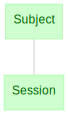

In [18]:
dj.Diagram(schema)

In [19]:
Session()

subject_name,sample_number sample number,session_date date of session in YYYY-MM-DD format,stimulations list of dicts for stimulations


In [20]:
Session.insert(data, skip_duplicates=True)

In [21]:
Session()

subject_name,sample_number sample number,session_date date of session in YYYY-MM-DD format,stimulations list of dicts for stimulations
KO (chx10),1,2008-06-06,=BLOB=
KO (chx10),2,2008-06-06,=BLOB=
KO (chx10),2,2008-06-24,=BLOB=
KO (chx10),3,2008-06-06,=BLOB=
KO (chx10),3,2008-06-24,=BLOB=
KO (chx10),4,2008-07-02,=BLOB=
KO (pax6),1,2008-05-16,=BLOB=
KO (pax6),2,2008-05-16,=BLOB=
KO (pax6),2,2008-06-28,=BLOB=
KO (pax6),3,2008-06-28,=BLOB=


#### Stimulations Table

The stimulations will each be stored as a `dj.Computed` table that is dependent on a given `Session`. We use the `dj.Computed` table tier because the imported data comes from the provided pickle file, whose contents are stored in our database.

**Note:** One Session can have zero or more stimulations

In [22]:
@schema
class Stimulations(dj.Computed):
    definition = """
    -> Session
    stim_id:           int
    ---
    fps=0:             float         # frames per second of movie
    movie=null:        longblob      # numpy array of movie stimulus shaped as (horiz blocks, vert blocks, frames)
    n_frames:          int           # integer number of frames
    pixel_size=0:      float         # pixel size on retina in um/pixel
    stim_height=0:     int           # height of stimulus in pixels
    stim_width=0:      int           # width of the stimulus in pixels
    stimulus_onset=0:  float         # onset of stimulus in seconds from start of recording
    x_block_size=0:    int           # size of horizontal blocks in pixels
    y_block_size=0:    int           # size of vertical blocks in pixels
    spikes=null:       longblob      # list of spike times for recorded neurons, each element is np.ndarray()
    """
    def make(self, key):
        # load stimulations for a given key as a list
        stims = (Session() & key).fetch1('stimulations')
        
        
        print('Populating stimulation(s) for subject_name={subject_name}, sample_number={sample_number} on session_date={session_date}'.format(**key))
        
        for idx, item in enumerate(stims):
            key['stim_id'] = idx
            key['fps'] = item['fps']
            key['n_frames'] = item['n_frames']
            key['movie'] = item['movie']
            key['pixel_size'] = item['pixel_size']
            key['stim_height'] = item['stim_height']
            key['stim_width'] = item['stim_width']
            key['stimulus_onset'] = item['stimulus_onset']
            key['x_block_size'] = item['x_block_size']
            key['y_block_size'] = item['y_block_size']
            key['spikes'] = item['spikes']
            
            # Insert key into self
            self.insert1(key)
            
            print('\tPopulated stimulation {stim_id}'.format(**key))

In [23]:
Stimulations.populate()

Populating stimulation(s) for subject_name=KO (chx10), sample_number=1 on session_date=2008-06-06
	Populated stimulation 0
Populating stimulation(s) for subject_name=KO (chx10), sample_number=2 on session_date=2008-06-06
	Populated stimulation 0
Populating stimulation(s) for subject_name=KO (chx10), sample_number=2 on session_date=2008-06-24
	Populated stimulation 0
Populating stimulation(s) for subject_name=KO (chx10), sample_number=3 on session_date=2008-06-06
	Populated stimulation 0
Populating stimulation(s) for subject_name=KO (chx10), sample_number=3 on session_date=2008-06-24
	Populated stimulation 0
Populating stimulation(s) for subject_name=KO (chx10), sample_number=4 on session_date=2008-07-02
	Populated stimulation 0
	Populated stimulation 1
Populating stimulation(s) for subject_name=KO (pax6), sample_number=1 on session_date=2008-05-16
	Populated stimulation 0
Populating stimulation(s) for subject_name=KO (pax6), sample_number=2 on session_date=2008-05-16
	Populated stimula

In [24]:
Stimulations()

subject_name,sample_number sample number,session_date date of session in YYYY-MM-DD format,stim_id,fps frames per second of movie,"movie numpy array of movie stimulus shaped as (horiz blocks, vert blocks, frames)",n_frames integer number of frames,pixel_size pixel size on retina in um/pixel,stim_height height of stimulus in pixels,stim_width width of the stimulus in pixels,stimulus_onset onset of stimulus in seconds from start of recording,x_block_size size of horizontal blocks in pixels,y_block_size size of vertical blocks in pixels,"spikes list of spike times for recorded neurons, each element is np.ndarray()"
KO (chx10),1,2008-06-06,0,59.9815,=BLOB=,3823,8.3,480,640,1.65657,1,480,=BLOB=
KO (chx10),2,2008-06-06,0,59.9815,=BLOB=,4377,8.3,480,640,1.77267,640,1,=BLOB=
KO (chx10),2,2008-06-24,0,59.9815,=BLOB=,4125,8.3,300,640,1.22127,10,10,=BLOB=
KO (chx10),3,2008-06-06,0,59.9815,=BLOB=,4241,8.3,480,640,1.00227,10,10,=BLOB=
KO (chx10),3,2008-06-24,0,59.9816,=BLOB=,4348,8.3,480,640,1.05317,5,480,=BLOB=
KO (chx10),4,2008-07-02,0,60.005,=BLOB=,4156,8.3,480,640,1.3066,2,480,=BLOB=
KO (chx10),4,2008-07-02,1,29.9908,=BLOB=,3854,8.3,320,640,1.2634,8,8,=BLOB=
KO (pax6),1,2008-05-16,0,59.9816,=BLOB=,4325,8.3,480,640,1.2488,10,10,=BLOB=
KO (pax6),2,2008-05-16,0,59.9816,=BLOB=,4331,8.3,480,640,1.0617,1,480,=BLOB=
WT (chx10 het),1,2008-06-24,0,59.9815,=BLOB=,3938,8.3,480,640,6.65177,640,2,=BLOB=


/home/rohit/miniconda3/envs/datajoint_interview/lib/python3.8/inspect.py:350: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/home/rohit/miniconda3/envs/datajoint_interview/lib/python3.8/inspect.py:350: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/home/rohit/miniconda3/envs/datajoint_interview/lib/python3.8/inspect.py:350: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)


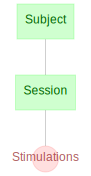

In [25]:
dj.Diagram(schema)

### Spike trains table

The next entity we care about are the spike trains associated with Stimulation. We can use another `dj.Computed` table here.

Each stimulation's `spikes` attribute contains a list of numpy arrays for the spike times (in seconds) for each neuron, of which there can be one or more.

**Note:** The spike times are from the start of data recording, so we want to subtract the `stimulus_onset` attribute from all the spike times to get the spike times after the stimulus.

In [26]:
keys = Stimulations.fetch('KEY')

In [27]:
(Stimulations() & keys[2]).fetch1('spikes')[25].reshape(-1) - (Stimulations() & keys[2]).fetch1('stimulus_onset')

array([ 0.14363,  0.40973,  0.41673,  0.42453,  0.43683,  0.47323,
        1.81403, 24.24853, 30.38023, 35.30763, 35.31733, 35.33163,
       41.05963, 42.10843, 42.11673, 42.13593, 45.36173, 45.37083,
       45.40223, 56.59663, 56.60973, 56.62823, 67.61533, 67.62493,
       67.63453])

In [28]:
(Stimulations() & keys[2]).fetch1('movie').shape

(64, 30, 4125)

In [29]:
@schema
class SpikeTrain(dj.Computed):
    definition = """
    -> Stimulations
    neuron_id:           int
    ---
    spike_times=null:    longblob      # numpy array of spike times AFTER stimulus onset
    """
    def make(self, key):
        # load stimulations for a given key as a list
        spike_trains = (Stimulations() & key).fetch1('spikes')
        
        
        print('Populating spike train(s) for subject_name={subject_name}, sample_number={sample_number} on session_date={session_date} for stim_id={stim_id}'.format(**key))
        
        for idx, item in enumerate(spike_trains):
            key['neuron_id'] = idx
            
            # subtract onset time from spike times to see the spike times in relation to the stimulus
            key['spike_times'] = item.reshape(-1,) - (Stimulations() & key).fetch1('stimulus_onset')
            
            # Insert key into self
            self.insert1(key)
            
            print('\tPopulated spike times for neuron {neuron_id}'.format(**key))

In [30]:
SpikeTrain.populate()

Populating spike train(s) for subject_name=KO (chx10), sample_number=1 on session_date=2008-06-06 for stim_id=0
	Populated spike times for neuron 0
	Populated spike times for neuron 1
	Populated spike times for neuron 2
	Populated spike times for neuron 3
Populating spike train(s) for subject_name=KO (chx10), sample_number=2 on session_date=2008-06-06 for stim_id=0
	Populated spike times for neuron 0
	Populated spike times for neuron 1
	Populated spike times for neuron 2
	Populated spike times for neuron 3
	Populated spike times for neuron 4
	Populated spike times for neuron 5
Populating spike train(s) for subject_name=KO (chx10), sample_number=2 on session_date=2008-06-24 for stim_id=0
	Populated spike times for neuron 0
	Populated spike times for neuron 1
	Populated spike times for neuron 2
	Populated spike times for neuron 3
	Populated spike times for neuron 4
	Populated spike times for neuron 5
	Populated spike times for neuron 6
	Populated spike times for neuron 7
	Populated spike

In [31]:
SpikeTrain()

subject_name,sample_number sample number,session_date date of session in YYYY-MM-DD format,stim_id,neuron_id,spike_times numpy array of spike times AFTER stimulus onset
KO (chx10),1,2008-06-06,0,0,=BLOB=
KO (chx10),1,2008-06-06,0,1,=BLOB=
KO (chx10),1,2008-06-06,0,2,=BLOB=
KO (chx10),1,2008-06-06,0,3,=BLOB=
KO (chx10),2,2008-06-06,0,0,=BLOB=
KO (chx10),2,2008-06-06,0,1,=BLOB=
KO (chx10),2,2008-06-06,0,2,=BLOB=
KO (chx10),2,2008-06-06,0,3,=BLOB=
KO (chx10),2,2008-06-06,0,4,=BLOB=
KO (chx10),2,2008-06-06,0,5,=BLOB=


/home/rohit/miniconda3/envs/datajoint_interview/lib/python3.8/inspect.py:350: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/home/rohit/miniconda3/envs/datajoint_interview/lib/python3.8/inspect.py:350: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/home/rohit/miniconda3/envs/datajoint_interview/lib/python3.8/inspect.py:350: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)


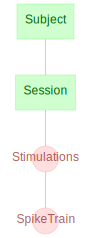

In [32]:
dj.Diagram(schema)

This concludes **Part 1**. 

### Part (2) of the challenge - Compute Spatio-Temporal Receptive Fields (STRF)

In order to compute the STRF, we need to make use of the other attributes in the `Stimulations()` table. 

In [33]:
Stimulations()

subject_name,sample_number sample number,session_date date of session in YYYY-MM-DD format,stim_id,fps frames per second of movie,"movie numpy array of movie stimulus shaped as (horiz blocks, vert blocks, frames)",n_frames integer number of frames,pixel_size pixel size on retina in um/pixel,stim_height height of stimulus in pixels,stim_width width of the stimulus in pixels,stimulus_onset onset of stimulus in seconds from start of recording,x_block_size size of horizontal blocks in pixels,y_block_size size of vertical blocks in pixels,"spikes list of spike times for recorded neurons, each element is np.ndarray()"
KO (chx10),1,2008-06-06,0,59.9815,=BLOB=,3823,8.3,480,640,1.65657,1,480,=BLOB=
KO (chx10),2,2008-06-06,0,59.9815,=BLOB=,4377,8.3,480,640,1.77267,640,1,=BLOB=
KO (chx10),2,2008-06-24,0,59.9815,=BLOB=,4125,8.3,300,640,1.22127,10,10,=BLOB=
KO (chx10),3,2008-06-06,0,59.9815,=BLOB=,4241,8.3,480,640,1.00227,10,10,=BLOB=
KO (chx10),3,2008-06-24,0,59.9816,=BLOB=,4348,8.3,480,640,1.05317,5,480,=BLOB=
KO (chx10),4,2008-07-02,0,60.005,=BLOB=,4156,8.3,480,640,1.3066,2,480,=BLOB=
KO (chx10),4,2008-07-02,1,29.9908,=BLOB=,3854,8.3,320,640,1.2634,8,8,=BLOB=
KO (pax6),1,2008-05-16,0,59.9816,=BLOB=,4325,8.3,480,640,1.2488,10,10,=BLOB=
KO (pax6),2,2008-05-16,0,59.9816,=BLOB=,4331,8.3,480,640,1.0617,1,480,=BLOB=
WT (chx10 het),1,2008-06-24,0,59.9815,=BLOB=,3938,8.3,480,640,6.65177,640,2,=BLOB=


The computations will then all be done on each `spike_times` entry in `SpikeTrain()`.

In [34]:
SpikeTrain()

subject_name,sample_number sample number,session_date date of session in YYYY-MM-DD format,stim_id,neuron_id,spike_times numpy array of spike times AFTER stimulus onset
KO (chx10),1,2008-06-06,0,0,=BLOB=
KO (chx10),1,2008-06-06,0,1,=BLOB=
KO (chx10),1,2008-06-06,0,2,=BLOB=
KO (chx10),1,2008-06-06,0,3,=BLOB=
KO (chx10),2,2008-06-06,0,0,=BLOB=
KO (chx10),2,2008-06-06,0,1,=BLOB=
KO (chx10),2,2008-06-06,0,2,=BLOB=
KO (chx10),2,2008-06-06,0,3,=BLOB=
KO (chx10),2,2008-06-06,0,4,=BLOB=
KO (chx10),2,2008-06-06,0,5,=BLOB=


The **Spike-triggered Average (STA)** is defined (on Wikipedia) as:
> Mathematically, the STA is the average stimulus preceding a spike. To compute the STA, the stimulus in the time window preceding each spike is extracted, and the resulting (spike-triggered) stimuli are averaged.

In our case, we are told our stimulus vector for the $i$'th time bin, $\mathbf{x_i}$, is *white noise* , so the Standard STA definition on Wikipedia should do.

This is:

\begin{equation}
    \mathrm{STA} = \frac{1}{n_{sp}} \sum_{i=1}^{T}{y_i \mathbf{x_i}},
\end{equation}
where $T$ is the total number of time bins, $y_i$ is the number of spikes in bin $i$, and $n_{sp} = \sum y_i$ is the total number of spikes.

In matrix form, we can let the rows of a matrix $X$ be equal to $\mathbf{x_i}^T$ and a column vector $\mathbf{y}$ whose $i$'th element can be equal to $y_i$. Then we have

\begin{equation}
    \mathrm{STA} = \frac{1}{n_{sp}} X^T \mathbf{y}
\end{equation}

In order to do this for our experiment, we need to determine a time bin/window size for each recording, which we can do with some trial and error for now.

We have to consider the following in our experiment:
 * Time bin window size in seconds (maybe a parameter we can set with a `Lookup` table)
 * Segment of the movie to match this time in seconds to determine the size of $\mathbf{x_i}$.
   * We may need to use the `n_frames`, `framerate`, `x_block_size`, `y_block_size`, and the `movie` array to determine these
 * Count the number of spikes in each time bin and total number of spikes to determine $y_i$ and $n_{sp}$
 

**Note**: I am not 100% certain about my method here, since the stimulus $\mathbf{x_{i}}$ is supposed to *precede* the spike count in bin $i$, but they are indexed the same way in the equation. For the sake of simplicity, I am considering the stimulus and spike count in the same bin, and will try different bin sizes (presumably needs to be a sufficiently large bin for this to be approximately correct).

### Just playing around trying to understand how to compute STA with a single example with a fixed window size

In [35]:
def count_spikes_in_bin(times, spikes):
    start = times[0]
    stop = times[-1]
    mask = np.logical_and(spikes >= start, spikes < stop) 
    return len(spikes[mask])

In [36]:
keys = SpikeTrain.fetch('KEY')

window_size = 5

movie = (Stimulations() & keys[2]).fetch1('movie')
movie_dims = movie.shape

n_fr = movie_dims[2]

fr = (Stimulations() & keys[2]).fetch1('fps')

x_size = (Stimulations() & keys[2]).fetch1('x_block_size')
x_dim = (Stimulations() & keys[2]).fetch1('stim_width')

y_size = (Stimulations() & keys[2]).fetch1('y_block_size')
y_dim = (Stimulations() & keys[2]).fetch1('stim_height')


# Padding so I can reshape the index mask to the correct size given a particular frame count.
num_to_pad = window_size - n_fr % window_size  # maximum value padding amount
mask_indices = np.pad(np.arange(n_fr), (0, num_to_pad), mode='maximum').reshape(-1, window_size) 

spikes = (SpikeTrain() & keys[2]).fetch1('spike_times')

print(f'Movie has dimensions {movie_dims}')
print(f'FPS is {fr}')
print(f'Video dimensions are {x_dim} x {y_dim} with {movie_dims[2]} frames')
print(f'x_block_size is {x_size}')
print(f'y_block_size is {y_size}')

# create array of frame times
times = np.arange(0, n_fr) / fr

fr_times_windows = times[mask_indices]


spike_counts = np.apply_along_axis(lambda x: count_spikes_in_bin(x, spikes), axis=1, arr=fr_times_windows)

print(f'We have {fr_times_windows.shape[0]} bins of size {fr_times_windows.shape[1]}')
print('Sum of spike counts across all bins:', np.sum(spike_counts))
print('Length of original spike train array:', len(spikes))

Movie has dimensions (640, 1, 3823)
FPS is 59.9815
Video dimensions are 640 x 480 with 3823 frames
x_block_size is 1
y_block_size is 480
We have 765 bins of size 5
Sum of spike counts across all bins: 129
Length of original spike train array: 168


It looks like some spikes are being missed by my method, but the number gets closer as the window size increases based on trial/error experimentation.

In [37]:
windowed_movie = movie[:, :, mask_indices]

windowed_movie.shape

(640, 1, 765, 5)

Compute an average stimulus

In [38]:
average_movie = np.mean(windowed_movie, axis=3)

In [39]:
(average_movie @ spike_counts / np.sum(spike_counts)).shape

(640, 1)

Need to reshape to actual image size to store using block size

### Back to defining schema

In [40]:
# Define lookup table for STA parameters
@schema
class STRF_Param(dj.Lookup):
    definition = """
    strf_param_id:          int                # unique id for STRF parameter set
    ---
    bin_size=0:             float              # time window bin size in seconds
    """

In [41]:
# Try lots of window sizes in seconds
STRF_Param.insert([(0, 0.5),
                  ]
                 )

In [42]:
@schema
class STRF_Compute(dj.Computed):
    definition = """
    -> SpikeTrain
    -> STRF_Param
    ---
    n_spikes = null:         longblob    # array for number of spikes in each bin
    sta_values = null:       longblob    # STA at each time point
    """
    # Define a Part table for the STRF storage
    class STRF_Store(dj.Part):
        definition = """
        -> master
        ---
        strf:                longblob    # STRF computation over all windows
       """
    
    def make(self, key):
        window_seconds = (STRF_Param() & key).fetch1('bin_size')  # window/bin size in seconds
        
        # Next, we want to slide window over movie and spike train
        
        # Start by extracting the relevant parameters
        x_blocks = (Stimulations() & key).fetch1('x_block_size')
        y_blocks = (Stimulations() & key).fetch1('y_block_size')
        fr = (Stimulations() & key).fetch1('fps')
        n_fr = (Stimulations() & key).fetch1('n_frames')
        x_dim = (Stimulations() & key).fetch1('stim_width')
        y_dim = (Stimulations() & key).fetch1('stim_height')
        spikes = (SpikeTrain() & key).fetch1('spike_times')
        movie = (Stimulations() & key).fetch1('movie')
        
        # create a frame time array (which is found by dividing frame_number / framerate)
        frames = np.arange(0, n_fr)
        fr_times = frames / fr
        
        # Create sliding window mask for looking at subarrays of this fr_times array
        # compute best window size:
        window_size = round(window_seconds * fr)
        
        # Padding so I can reshape the index mask to the correct size given a particular frame count.
        num_to_pad = window_size - n_fr % window_size  # maximum value padding amount
        mask_indices = np.pad(np.arange(n_fr), (0, num_to_pad), mode='maximum').reshape(-1, window_size) 
        
        # mask frame times with sliding windows as rows
        fr_times_windows = fr_times[mask_indices]
        
        # Create spike_counts array, which is essentially the vector y in the definition above (spike counts for each bin)
        # Should replace this with a vectorized function, but I was running into some error that I can debug later to optimize, since this is slow.
        print('Populating spike counts for subject {subject_name}, sample {sample_number} on {session_date} with stim_id={stim_id} for neuron {neuron_id}'.format(**key))
        spike_counts = np.apply_along_axis(lambda x: count_spikes_in_bin(x, spikes), axis=1, arr=fr_times_windows)
        tot_spikes = np.sum(spike_counts)
        print(f'\tFound {tot_spikes} total spikes with window size of {window_seconds} seconds.')
        
        key['n_spikes'] = spike_counts
        
        # Compute STA for each of the windows
        windowed_movie = movie[:, :, mask_indices]
        average_movie = np.mean(windowed_movie, axis=3)
        sta = (average_movie @ spike_counts) / tot_spikes
        
        sta = np.repeat(sta, repeats=x_blocks, axis=0)
        sta = np.repeat(sta, repeats=y_blocks, axis=1)
        
        key['sta_values'] = sta
        
        self.insert1(key)

/home/rohit/miniconda3/envs/datajoint_interview/lib/python3.8/inspect.py:350: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/home/rohit/miniconda3/envs/datajoint_interview/lib/python3.8/inspect.py:350: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/home/rohit/miniconda3/envs/datajoint_interview/lib/python3.8/inspect.py:350: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/home/rohit/miniconda3/envs/datajoint_interview/lib/python3.8/inspect.py:350: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appro

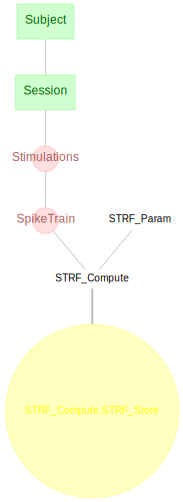

In [43]:
dj.Diagram(schema)

In [44]:
STRF_Compute.populate()

Populating spike counts for subject KO (chx10), sample 1 on 2008-06-06 with stim_id=0 for neuron 0
	Found 32 total spikes with window size of 0.5 seconds.
Populating spike counts for subject KO (chx10), sample 1 on 2008-06-06 with stim_id=0 for neuron 1
	Found 104 total spikes with window size of 0.5 seconds.
Populating spike counts for subject KO (chx10), sample 1 on 2008-06-06 with stim_id=0 for neuron 2
	Found 161 total spikes with window size of 0.5 seconds.
Populating spike counts for subject KO (chx10), sample 1 on 2008-06-06 with stim_id=0 for neuron 3
	Found 232 total spikes with window size of 0.5 seconds.
Populating spike counts for subject KO (chx10), sample 2 on 2008-06-06 with stim_id=0 for neuron 0
	Found 34 total spikes with window size of 0.5 seconds.
Populating spike counts for subject KO (chx10), sample 2 on 2008-06-06 with stim_id=0 for neuron 1
	Found 119 total spikes with window size of 0.5 seconds.
Populating spike counts for subject KO (chx10), sample 2 on 2008-0

/tmp/ipykernel_324310/2197644769.py:60: RuntimeWarning: invalid value encountered in true_divide
  sta = (average_movie @ spike_counts) / tot_spikes


Populating spike counts for subject WT (chx10 het), sample 1 on 2008-06-24 with stim_id=0 for neuron 8
	Found 1609 total spikes with window size of 0.5 seconds.
Populating spike counts for subject WT (chx10 het), sample 1 on 2008-06-24 with stim_id=0 for neuron 9
	Found 774 total spikes with window size of 0.5 seconds.
Populating spike counts for subject WT (chx10 het), sample 1 on 2008-06-24 with stim_id=0 for neuron 10
	Found 1442 total spikes with window size of 0.5 seconds.
Populating spike counts for subject WT (chx10 het), sample 1 on 2008-06-24 with stim_id=0 for neuron 11
	Found 51 total spikes with window size of 0.5 seconds.
Populating spike counts for subject WT (chx10 het), sample 1 on 2008-06-24 with stim_id=0 for neuron 12
	Found 705 total spikes with window size of 0.5 seconds.
Populating spike counts for subject WT (chx10 het), sample 1 on 2008-06-24 with stim_id=0 for neuron 13
	Found 1406 total spikes with window size of 0.5 seconds.
Populating spike counts for subjec

In [45]:
STRF_Compute()

subject_name,sample_number sample number,session_date date of session in YYYY-MM-DD format,stim_id,neuron_id,strf_param_id unique id for STRF parameter set,n_spikes array for number of spikes in each bin,sta_values STA at each time point
KO (chx10),1,2008-06-06,0,0,0,=BLOB=,=BLOB=
KO (chx10),1,2008-06-06,0,1,0,=BLOB=,=BLOB=
KO (chx10),1,2008-06-06,0,2,0,=BLOB=,=BLOB=
KO (chx10),1,2008-06-06,0,3,0,=BLOB=,=BLOB=
KO (chx10),2,2008-06-06,0,0,0,=BLOB=,=BLOB=
KO (chx10),2,2008-06-06,0,1,0,=BLOB=,=BLOB=
KO (chx10),2,2008-06-06,0,2,0,=BLOB=,=BLOB=
KO (chx10),2,2008-06-06,0,3,0,=BLOB=,=BLOB=
KO (chx10),2,2008-06-06,0,4,0,=BLOB=,=BLOB=
KO (chx10),2,2008-06-06,0,5,0,=BLOB=,=BLOB=


#### Check an example key

In [57]:
key = keys[38]

In [66]:
image = (STRF_Compute() & key).fetch1('sta_values')
image.shape

(640, 480)

In [67]:
image.shape

(640, 480)

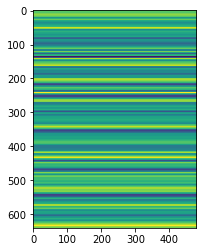

In [68]:
import matplotlib.pyplot as plt
plt.imshow(image)